## CUDA Vision Lab


# Assignment 1: Two layer neural network using numpy


In this task we implement a simple neural network (NN) with an imput and an output layer. We use MNIST for our experiments. 

In [1]:
# import some libraries
import os, struct
from array import array as pyarray
from numpy import  array, zeros
import numpy as np
from sklearn.utils import shuffle as skshuffle
from matplotlib import pyplot as plt


# Function to load mnist dataset

A simple function to load mnist dataset. Note: This function expects data files in a path $\textit{'data/raw/'}$ from a current directory.

In [2]:
def load_mnist(datafile='', labelfile=''):
    """
    Loads MNIST files into 3D numpy arrays 
    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    """
    DATA_PATH = 'data/raw/'
    images = open(DATA_PATH + datafile, 'rb')
    flabel = open(DATA_PATH + labelfile, 'rb')
    magic_nr, size = struct.unpack(">II", flabel.read(8))
    label = pyarray("b", flabel.read())
    flabel.close()

    magic_nr, size, rows, cols = struct.unpack(">IIII", images.read(16))
    img = pyarray("B", images.read())
    images.close()

    ind = [k for k in range(size) if label[k] in np.arange(10)]
    N = len(ind)

    images = zeros((N, rows, cols))
    labels = zeros((N ) )
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = label[ind[i]]

    return images, labels

# Neural Network 

We implement logistic regression for multi class classification as a 2 layer neural network. For this task we have implemented a class $\textbf{SimpleNN}$. We use softmax as a non-linearity and mean square error as a loss function. We encountered a problem of stability with softmax. To address the problem we use clipping which prevents exponent scores from divergence.

In [3]:
class SimpleNN:

    def __init__(self, n_in, n_out, alpha, batch_size, nm_iters, nonlin='softmax'):
        # Initializa various parameters for a NN
        self.n_in = n_in # Number of Input Neuron
        self.n_out = n_out # Number of Output Neuron
        self.alpha = alpha # Learning Rate
        self.batch_size = batch_size # Batch Size
        self.nm_iters = nm_iters # Number of iterations
        self.nonlin = nonlin # Type of non linearity
        self.W = np.random.randn(self.n_in, self.n_out) #Weight initialization
        self.bias = np.zeros(self.n_out) #Bias Initialization
        
    # Implement softmax as a non-linearity
    def softmax(self, x):
        # Clipping to ensure stability
        exp_scores = np.exp(x-np.max(x))
        prob = (exp_scores.T / np.sum(exp_scores, axis=1)).T
        return prob
    
    def MSElossfunc(self, y, pred):
        loss = np.sum(np.power((y-pred),2), axis=1)
        return np.sum(loss)
    
    # forward pass to compute probability scores
    def forward(self, X):
        # Forward Pass 
        pred = np.dot(X,self.W) + self.bias
        return self.softmax(pred)
    
    # for batchwise training, given function generates minibatches of data
    def get_minibatches(self, X, y, shuffle=True):
        minibatches = []
        X_shuff, y_shuff = np.copy(X), np.copy(y)
        if shuffle:
            X_shuff, y_shuff = skshuffle(X_shuff, y_shuff)
        for i in range(0, X_shuff.shape[0], self.batch_size):
            yield X_shuff[i:i + self.batch_size], y_shuff[i:i+self.batch_size]
    
    # batchwise training function
    def train(self, X, y):
        loss_iter = []
        for i in range(self.nm_iters):
            # Generate Mini-batches
            mb_iter = self.get_minibatches(X, y, shuffle=True)
            loss_mb = []
            for X_mb, y_mb in mb_iter:
                pred_mb = self.forward(X_mb)
                loss = self.MSElossfunc(y_mb, pred_mb)
                # Compute Gradients
                grad = np.copy(pred_mb)
                grad[range(self.batch_size),y_mb.argmax(axis=1)] -= 1
                gradL_W = 2*np.dot(X_mb.T, grad)
                gradL_b = 2*np.sum(grad, axis=0, keepdims=True).flatten()
                # Gradient Descent
                self.W -= self.alpha*gradL_W
                self.bias -= self.alpha*gradL_b
                loss_mb.append(loss)
            loss_ = np.mean(loss_mb)
            print(loss_)
            loss_iter.append(loss_)
        return loss_iter

Some utilities to visualize the loss and report the performance on test set

In [4]:
def plot_loss(loss):
    plt.plot(range(len(loss)), loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()  

def accuracy(pred_label, y_test):
    accuracy = sum(pred_label == y_test)/(float(len(y_test)))
    print('Accuracy {:.2f}'.format(accuracy))

To prevent divergence of loss we scale all images by the factor of 255 (maximum pixel value)

In [5]:
X_train, y_train = load_mnist(datafile='train-images-idx3-ubyte', labelfile='train-labels-idx1-ubyte')
X_train = np.reshape(X_train, (X_train.shape[0], -1))
# Encode label as one hot vector
y_train = y_train.reshape(1, y_train.shape[0])
y_train = np.eye(10)[y_train.astype('int32')]
y_train = y_train.reshape(y_train.shape[1], y_train.shape[2])

X_train = X_train /255
n_in = X_train.shape[1]
n_out = 10

alpha = 0.00001
batch_size = 200
nm_iters = 200
nonlin = 'softmax'
nn_model = SimpleNN(n_in, n_out, alpha, batch_size, nm_iters)

Training neural network

In [6]:
loss = nn_model.train(X_train, y_train)

303.012410182
285.432184992
269.440646294
254.522044862
238.917571875
223.260123916
208.868816412
196.241897898
185.410426447
176.051812748
167.841436648
160.716414874
154.327172134
148.594213971
143.524484795
138.924965861
134.712936626
130.879624546
127.416051245
124.219872247
121.337950097
118.634845844
116.10424539
113.773555406
111.638831368
109.612738828
107.730852566
105.945625372
104.235132952
102.653172228
101.150246218
99.7211373742
98.3716087048
97.0556932677
95.8385022838
94.643944925
93.5101030541
92.4365441889
91.3869231251
90.3893694161
89.419015682
88.4857063037
87.6220115022
86.7449314973
85.9140523965
85.118530876
84.3436008611
83.5973619795
82.8651232796
82.165185271
81.4831578703
80.8269101027
80.1802346765
79.5642246802
78.9506871054
78.3852376296
77.7979250344
77.2544705417
76.7075915349
76.1935161828
75.672169057
75.1817432382
74.6972411061
74.2182208317
73.7592613898
73.3018394009
72.8697144951
72.4351608133
72.0112759908
71.6025526141
71.1969716657
70.801751561

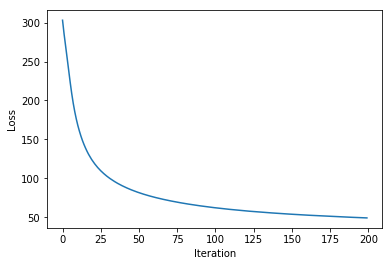

In [7]:
plot_loss(loss)

Load Test Data

In [8]:
X_test, y_test = load_mnist(datafile='t10k-images-idx3-ubyte', labelfile='t10k-labels-idx1-ubyte')
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_test = X_test /255

Test trained model

In [9]:
pred_test = nn_model.forward(X_test)
pred_label = np.argmax(pred_test, axis=1)
accuracy(pred_label, y_test)

Accuracy 0.85


In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_label))

             precision    recall  f1-score   support

        0.0       0.91      0.94      0.93       980
        1.0       0.94      0.95      0.94      1135
        2.0       0.86      0.83      0.84      1032
        3.0       0.83      0.85      0.84      1010
        4.0       0.84      0.85      0.85       982
        5.0       0.78      0.76      0.77       892
        6.0       0.90      0.88      0.89       958
        7.0       0.87      0.87      0.87      1028
        8.0       0.77      0.79      0.78       974
        9.0       0.81      0.79      0.80      1009

avg / total       0.85      0.85      0.85     10000

